In [1]:
# #install jupyter lib
# %pip install jupyter

#uncomment to install netgraph library
# %pip install netgraph

# Import the NetworkX package
import networkx as nx


### Degree Centrality of All Nodes
`neighborNodesDegree(G, U)` accepts a graph `G` and individual neighbor nodes `U` of node `V` and returns the sum of the degrees of the neighbor node `U` and its neighbors.

`centralityOfNodes(G)` accepts a graph `G` and return a dictionary of all nodes `V` and their centralities in the graph. It considers a 2-hop count neighbor nodes' degree centralities.

`baselineDegreeCentrality(G)` also accepts a graph `G` and return a dictionary of all nodes and their degree centralities in the graph, without considering neighbor nodes' centralities.

In [2]:
def neighborNodesDegree(G, U):
    degU = G.degree(U) #degree of U

    for w in G.neighbors(U):
        degU += G.degree(w)
    
    return degU

def centralityOfNodes(G):
    centralities = dict()

    #find the centralities of all nodes
    for V in G.nodes():
        degV = G.degree(V) #degree of V

        for U in G.neighbors(V):
            degV += neighborNodesDegree(G, U)
        
        #save centrality of each V
        centralities[V] = degV
    
    return centralities

def baselineDegreeCentrality(G):
    baseline_centralities = dict()

    #find the degree centralities of all nodes
    for V in G.nodes():
        #save centrality of each V
        baseline_centralities[V] = G.degree(V)
    
    return baseline_centralities
    

### Fuzzy Relation and NGC
`temporalFuzzyRelations(G, V)` accepts a graph `G` and a node `V` and returns a list of the fuzzy relations of all neighbors of `V`

The function `findNGCandFuzzyRelation(G, V, type='cdfr')` takes a graph `G`, a node `V`, and an optional parameter `type` that determines whether to use the baseline or cdfr algorithm and return the `NGC` node and `fuzzy relation` of node `V`.

In [3]:
import operator

def temporalFuzzyRelations(G, V):
    Xtemp = 0
    #store not visited nodes
    tempFuzzies = dict()
    
    len_vn = len(sorted(G.neighbors(V))) #length of node v neighbors

    for X in G.neighbors(V):
        vx_cn = nx.common_neighbors(G, V, X) #common neighbors(cn) of both V and X
        Xtemp = (1 + len(sorted(vx_cn))) / len_vn
        tempFuzzies[X] = Xtemp

    return tempFuzzies

def findNGCandFuzzyRelation(G, V, type="cdfr"):
    findtag = False
    W = V
    fuzzyrelation = 0
    closeTable = dict()
    
    #retrieve dictionary of node centralities
    if type == "baseline":
        nodeCentralities = baselineDegreeCentrality(G)
    else:
        nodeCentralities = centralityOfNodes(G)

    #retrieve dictionary of temporal fuzzy relations
    openTable = temporalFuzzyRelations(G, V)

    while len(openTable) != 0:
        #take node with maximum temporal fuzzy relation
        C = max(openTable.items(), key=operator.itemgetter(1))[0]

        #if we don't have an NGC
        if findtag == False:
            if nodeCentralities.get(C, 0) > nodeCentralities.get(V, 0):
                W = C
                fuzzyrelation = openTable.get(C)
                findtag = True
        else:
            if openTable.get(C) < fuzzyrelation:
                break

            if nodeCentralities.get(C, 0) > nodeCentralities.get(W, 0):
                W = C
                fuzzyrelation = openTable.get(C)
    
        closeTable[C] = openTable.get(C)

        #remove node and its value but return value -> default to return None to prevent KeyError
        CtmpFR = openTable.pop(C, None) 

        len_cn = len(sorted(G.neighbors(C))) #length of node c neighbors
        currentfr = 0

        for Y in G.neighbors(C):
            cy_cn = nx.common_neighbors(G, C, Y) #common neighbors(cn) of both C and Y
            currentfr = (1 + len(sorted(cy_cn))) / len_cn
            currentfr *= CtmpFR

            openTableContainsY = openTable.get(Y, None)
            closeTableContainsY = closeTable.get(Y, None)
            if openTableContainsY == None and closeTableContainsY == None:
                openTable[Y] = currentfr
            elif openTableContainsY != None:
                if currentfr > openTableContainsY:
                    openTable[Y] = currentfr
            elif closeTableContainsY != None:
                if currentfr > closeTableContainsY:
                    openTable[Y] = currentfr
                    closeTable.pop(Y, None)

    return W, fuzzyrelation

### Constructing Community Structure
The function `constructCommunityStructure(G, delta, type="cdfr")` takes in a graph `G`, a threshold value `delta`, and an optional parameter `type` defaulted to the value cdfr and returns a list of recognized communities in the network. The `delta` value controls how many communities can be recognized and it is picked from the decision graphs constructed from the network.

In [4]:
def constructCommuityStructure(G, delta, type="cdfr"):
    #retrieve and sort nodes' centralities
    if type == "baseline":
        centralities = baselineDegreeCentrality(G)
    else:
        centralities = centralityOfNodes(G)

    centralities =dict(sorted(centralities.items(), key=lambda item: item[1], reverse=True))

    communities = dict()
    comnumber = -1
    
    for V in centralities:
        ngc, fr = findNGCandFuzzyRelation(G, V, type)
        if fr < delta:
            comnumber += 1
            communities[comnumber] = [V]
        else:
            #find the community number of ngc
            for comnum, com in communities.items():
                if ngc in com:
                    #add V to the community ngc of V belongs
                    communities[comnum].append(V)
                    break
            
    return communities


### Util Functions
The function `draw(G, refinedData, datasetName)` visualizes the constructed communities in a graph using the [Netgraph](https://netgraph.readthedocs.io/en/stable/) library. It accepts a graph `G`, a `refinedData` from the function `nodeToCommunity(G, delta, type='cdfr')` (that returns a list of nodes and their associated communities), a string `datasetName` which is the name of the dataset used, and an optional parameter `type` that differentiate the baseline algorithm from the cdfr algorithm.

In [12]:
# import matplot library
import matplotlib.pyplot as plt

#install and import netgraph
from netgraph import Graph

# for Notebook
%matplotlib inline

def draw(G, refinedData, datasetName):
    #colors for various communities
    community_to_color = {
        0 : 'tab:blue', 1 : 'tab:orange', 2 : 'tab:green', 3 : 'tab:red', 4 : 'tab:purple',
        5 : 'tab:cyan', 6 : 'tab:brown', 7 : 'tab:pink', 8 : 'tab:olive', 9 : 'yellow', 
        10 : 'aqua', 11 : 'tab:grey', 12 : 'maroon', 13 : 'lime', 14 : 'olive', 15 : 'navy', 
        16 : 'coral', 17 : 'indigo', 18 : 'red',19 : 'green' 
    }
    
   
    #extract node_to_community, original communities and delta values
    node_to_community, communities, delta = refinedData
    
    #get number of communities detected
    com_len = len(communities)
    
    try:
        node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}
            
        #set node size and scale based on number of communities
        #to give some spacing/scaling to dense communities
        if com_len > 4:
            node_size = 7.0
            scale = (2.0, 2.0)
        else:
            node_size = 8.0
            scale = (1.2, 1.2)

        #maintain a window scale of 2.0 for networks with over 50 nodes    
        if len(node_to_community) > 50:
            scale = (2.0, 2.0)
            
        #set netgraph graph parameters    
        Graph(G,
        node_color=node_color, node_edge_width=0, edge_alpha=0.4, node_size=node_size,
        node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
        edge_layout='straight', edge_layout_kwargs=dict(k=2000), node_labels=True,
        edge_color="tab:grey", scale=scale
        )

        plt.title("{}: {} communities with delta={}".format(datasetName, com_len, delta))
        
        #save image of community graph
        filename = datasetName.replace(" ", "_")+"_delta_"+str(delta)
        plt.savefig("graphs/communities/{}".format(filename.lower()+".png"), format="PNG", dpi=400)
        plt.show()
    except:
        print("Delta: {} {} Communities Detected: {}".format(delta, datasetName, com_len))
              
        print("Cannot visualize more than 20 communities. Reduce Delta value")
    


def nodeToCommunity(G, delta, type="cdfr"):
    communities = constructCommuityStructure(G, delta, type)
    node_to_community = dict()

    #flatten communities to nodes
    for comnum, com in communities.items():
        for node in com:
            node_to_community[node] = comnum
            
    return node_to_community, communities, delta

### Dataset Setup & Constructing Decision Graphs
Decision graphs help in detecting the communities by aiding us to choose a delta value.

The function `decisionGraphs(G, datasetName, type='cdfr')` takes a graph `G`, a `datasetName`, and an optional parameter `type` and visualize a decision graph of the network.

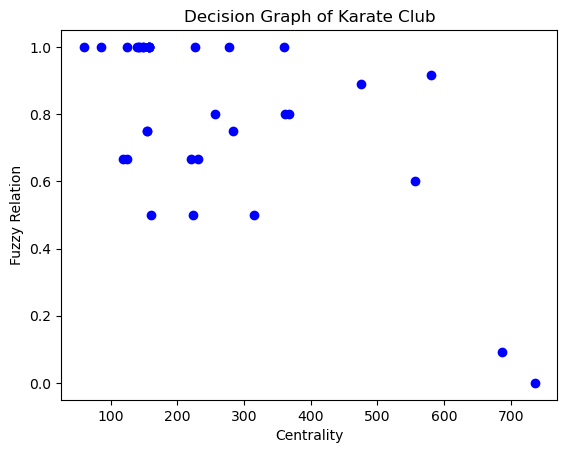

In [10]:
def decisionGraphs(G, datasetName, type = "cdfr"):
    fuzzies = list()

    #retrieve fuzzy relations of all nodes
    for V in G.nodes():
        ngc, fr = findNGCandFuzzyRelation(G, V, type)
        fuzzies.append(fr)

    #get centrality of all nodes
    if type == "baseline":
        centralities = list(baselineDegreeCentrality(G).values())
    else:
        centralities = list(centralityOfNodes(G).values())

    plt.title("Decision Graph of {}".format(datasetName))
    plt.xlabel('Centrality')
    plt.ylabel('Fuzzy Relation')
    plt.scatter(centralities, fuzzies, c="b")
    
    # save image of decision graph
    filename = datasetName.replace(" ", "_").lower()
    plt.savefig("graphs/decisions/{}".format(filename+"_decision_graph"+".png"), format="PNG", dpi=400)


K = nx.karate_club_graph()
decisionGraphs(K, "Karate Club")
# decisionGraphs(K, "Karate Club Baseline", "baseline")

# D = nx.read_gml("datasets/dolphins.gml")
# D = nx.convert_node_labels_to_integers(D,first_label=0)
# decisionGraphs(D, "Dolphins Network")

# F = nx.read_gml("datasets/football.gml")
# F = nx.convert_node_labels_to_integers(F,first_label=0)
# decisionGraphs(F, "Football")
# decisionGraphs(F, "Football Baseline", "baseline")


# P = nx.read_gml("datasets/us_politics_books.gml")
# P = nx.convert_node_labels_to_integers(P,first_label=0)
# decisionGraphs(P, "US Politics Books")

# FB = nx.read_edgelist("datasets/facebook686.edges")
# # FB = nx.read_edgelist("datasets/facebook414.edges")
# FB = nx.convert_node_labels_to_integers(FB,first_label=0)
# decisionGraphs(FB, "Facebook 686 Edges")

# T = nx.read_edgelist("datasets/twitter.edges")
# decisionGraphs(T, "Twitter")

# GP = nx.read_edgelist("datasets/googleplus.edges")
# decisionGraphs(GP, "Google Plus")


### Dataset Setup & Graph Visualization
Some datasets needed to be converted to have their integer labels instead of string labels to aid in readability of the graphs.

Change the decimal values in the `nodeToCommunity(G, 0.x, type='cdfr')` to realize different communities.

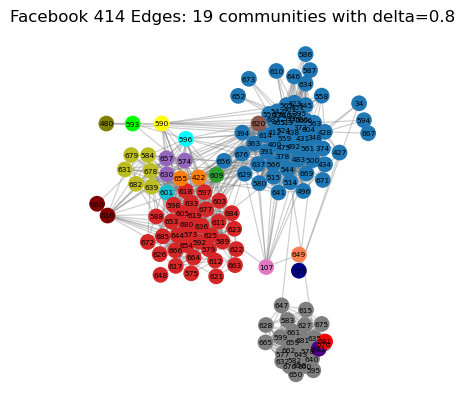

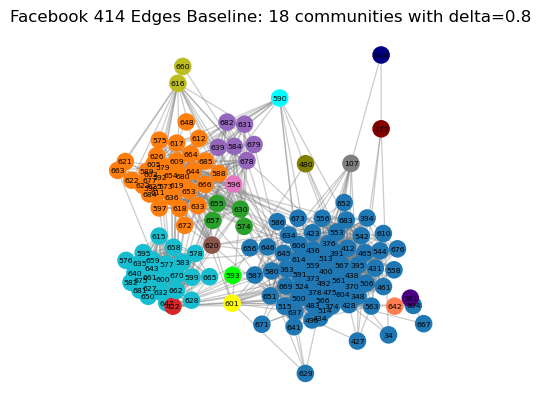

In [18]:
#DATASETS AND GRAPHS
#Karate Club
# K = nx.karate_club_graph()
# draw(K, nodeToCommunity(K, 0.6), "Karate Club")
# draw(K, nodeToCommunity(K, 0.4, "baseline"), "Karate Club Baseline")

# # #Dolphin
# D = nx.read_gml("datasets/dolphins.gml")
# D = nx.convert_node_labels_to_integers(D,first_label=0)
# draw(D, nodeToCommunity(D, 0.2), "Dolphins Network")
# draw(D, nodeToCommunity(D, 0.2, "baseline"), "Dolphins Network Baseline")


# # #Football
# F = nx.read_gml("datasets/football.gml")
# F = nx.convert_node_labels_to_integers(F,first_label=0)
# draw(F, nodeToCommunity(F, 0.5), "Football")
# draw(F, nodeToCommunity(F, 0.05, "baseline"), "Football Baseline")

# #US Politics Books
# P = nx.read_gml("datasets/us_politics_books.gml")
# P = nx.convert_node_labels_to_integers(P,first_label=0)
# draw(P, nodeToCommunity(P, 0.40), "US Politics Books")
# draw(P, nodeToCommunity(P, 0.15, "baseline"), "US Politics Books Baseline")

# # #Facebook
# FB6 = nx.read_edgelist("datasets/facebook686.edges")
# draw(FB6, nodeToCommunity(FB6, 0.6), "Facebook 686 Edges")
# draw(FB6, nodeToCommunity(FB6, 0.4, "baseline"), "Facebook 686 Edges Baseline")

FB4 = nx.read_edgelist("datasets/facebook414.edges")
draw(FB4, nodeToCommunity(FB4, 0.8), "Facebook 414 Edges")
draw(FB4, nodeToCommunity(FB4, 0.8, "baseline"), "Facebook 414 Edges Baseline")

# # #Twitter
# T = nx.read_edgelist("datasets/twitter.edges")
# draw(T, nodeToCommunity(T, 0.72), "Twitter Edges")
# draw(T, nodeToCommunity(T, 0.93), "Twitter Edges Baseline", "baseline")

# # Google Plus
# GP = nx.read_edgelist("datasets/googleplus.edges")
# draw(GP, nodeToCommunity(GP, 0.72), "Google Plus Edges")
# draw(GP, nodeToCommunity(GP, 0.8), "Google Plus Edges Baseline", "baseline")